# **Plant seedlings classifier using MobileNetV3**

In [1]:
#import data by kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d gpiosenka/100-bird-species

100% 1.69G/1.69G [01:15<00:00, 25.2MB/s]
100% 1.69G/1.69G [01:15<00:00, 24.1MB/s]


In [4]:
#file unzip
import zipfile
zip_ref = zipfile.ZipFile('/content/100-bird-species.zip')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import PIL
import pathlib

import tensorflow as tf
from tensorflow import keras

In [7]:
train_dir = pathlib.Path('/content/train')
val_dir = pathlib.Path('/content/valid')
test_dir = pathlib.Path('/content/test')
train_image_count = len(list(train_dir.glob('*/*.jpg')))
train_image_count

70626

In [8]:
batch_size = 32
image_width = 224
image_height = 224

train_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=123,
    #validation_split=0.5,
    #subset='training',
    image_size=(image_height, image_width),
    batch_size=batch_size
)

val_ds = keras.preprocessing.image_dataset_from_directory(
    val_dir,
    seed=123,
    image_size=(image_height, image_width),
    batch_size=batch_size
)

test_ds = keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=(image_height, image_width),
    batch_size=batch_size
)

Found 70626 files belonging to 450 classes.
Found 2250 files belonging to 450 classes.
Found 2250 files belonging to 450 classes.


In [10]:
#check data class
class_names = train_ds.class_names 
class_names

['ABBOTTS BABBLER',
 'ABBOTTS BOOBY',
 'ABYSSINIAN GROUND HORNBILL',
 'AFRICAN CROWNED CRANE',
 'AFRICAN EMERALD CUCKOO',
 'AFRICAN FIREFINCH',
 'AFRICAN OYSTER CATCHER',
 'AFRICAN PIED HORNBILL',
 'ALBATROSS',
 'ALBERTS TOWHEE',
 'ALEXANDRINE PARAKEET',
 'ALPINE CHOUGH',
 'ALTAMIRA YELLOWTHROAT',
 'AMERICAN AVOCET',
 'AMERICAN BITTERN',
 'AMERICAN COOT',
 'AMERICAN FLAMINGO',
 'AMERICAN GOLDFINCH',
 'AMERICAN KESTREL',
 'AMERICAN PIPIT',
 'AMERICAN REDSTART',
 'AMERICAN WIGEON',
 'AMETHYST WOODSTAR',
 'ANDEAN GOOSE',
 'ANDEAN LAPWING',
 'ANDEAN SISKIN',
 'ANHINGA',
 'ANIANIAU',
 'ANNAS HUMMINGBIRD',
 'ANTBIRD',
 'ANTILLEAN EUPHONIA',
 'APAPANE',
 'APOSTLEBIRD',
 'ARARIPE MANAKIN',
 'ASHY STORM PETREL',
 'ASHY THRUSHBIRD',
 'ASIAN CRESTED IBIS',
 'ASIAN DOLLARD BIRD',
 'AUCKLAND SHAQ',
 'AUSTRAL CANASTERO',
 'AUSTRALASIAN FIGBIRD',
 'AVADAVAT',
 'AZARAS SPINETAIL',
 'AZURE BREASTED PITTA',
 'AZURE JAY',
 'AZURE TANAGER',
 'AZURE TIT',
 'BAIKAL TEAL',
 'BALD EAGLE',
 'BALD IBIS',
 'BALI

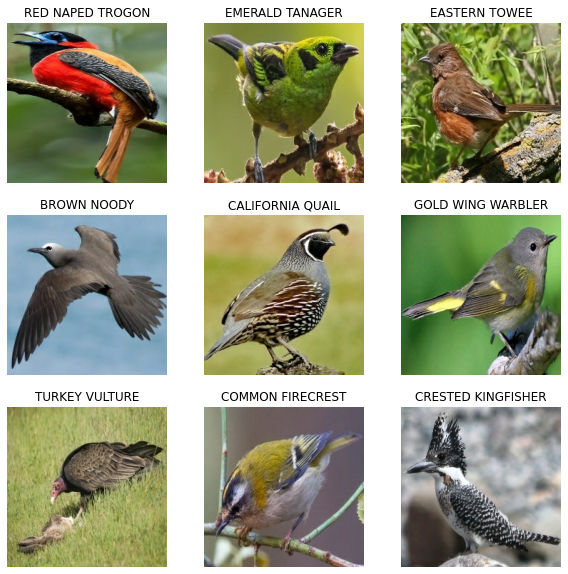

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [12]:
# Criando o modelo base em cima do modelo MobileNetV3
base_model = keras.applications.MobileNetV3Small(input_shape=(image_width, image_height, 3),
                                            classes=400,
                                            include_top=False,
                                            weights='imagenet')

4334752/4334752 [==============================] - 0s 0us/step


In [13]:
# Freeze convolutional base
base_model.trainable = False
base_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

In [14]:
data_augmentation = keras.models.Sequential([
  keras.layers.RandomFlip('horizontal'),
  keras.layers.RandomRotation(0.2)
])

In [15]:
num_classes = len(class_names)# 7

inputs = keras.Input(shape=(image_width, image_height, 3))
#x = data_augmentation(inputs)
x = keras.applications.mobilenet_v3.preprocess_input(inputs)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)


outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [16]:
#compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 576)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 450)               259650    
                                                                 
Total params: 1,198,770
Trainable params: 259,650
Non-trainab

In [17]:
#fitting model
initial_epochs = 10

early_stop = keras.callbacks.EarlyStopping(patience=1, restore_best_weights=True)

history = model.fit(train_ds, 
          validation_data=val_ds,
          epochs=initial_epochs,
          callbacks=[early_stop])

Epoch 1/10
2208/2208 [==============================] - 111s 45ms/step - loss: 1.7208 - accuracy: 0.6713 - val_loss: 0.5183 - val_accuracy: 0.9004
Epoch 2/10
2208/2208 [==============================] - 97s 44ms/step - loss: 0.6298 - accuracy: 0.8544 - val_loss: 0.3399 - val_accuracy: 0.9271
Epoch 3/10
2208/2208 [==============================] - 94s 43ms/step - loss: 0.4744 - accuracy: 0.8827 - val_loss: 0.2855 - val_accuracy: 0.9360
Epoch 4/10
2208/2208 [==============================] - 100s 45ms/step - loss: 0.3923 - accuracy: 0.9010 - val_loss: 0.2500 - val_accuracy: 0.9422
Epoch 5/10
2208/2208 [==============================] - 89s 40ms/step - loss: 0.3426 - accuracy: 0.9105 - val_loss: 0.2365 - val_accuracy: 0.9404
Epoch 6/10
2208/2208 [==============================] - 89s 40ms/step - loss: 0.3076 - accuracy: 0.9184 - val_loss: 0.2285 - val_accuracy: 0.9418
Epoch 7/10
2208/2208 [==============================] - 86s 39ms/step - loss: 0.2804 - accuracy: 0.9233 - val_loss: 0.2075

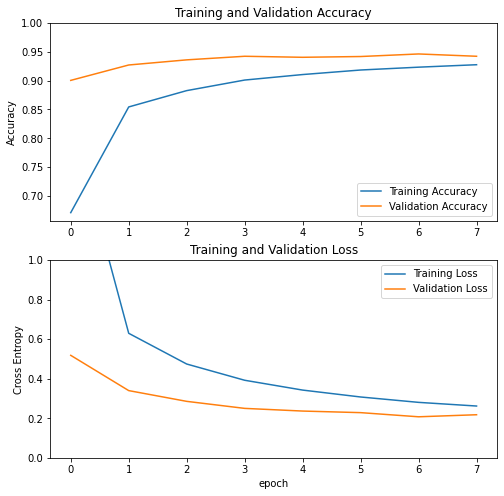

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

1/1 [==============================] - 1s 1s/step


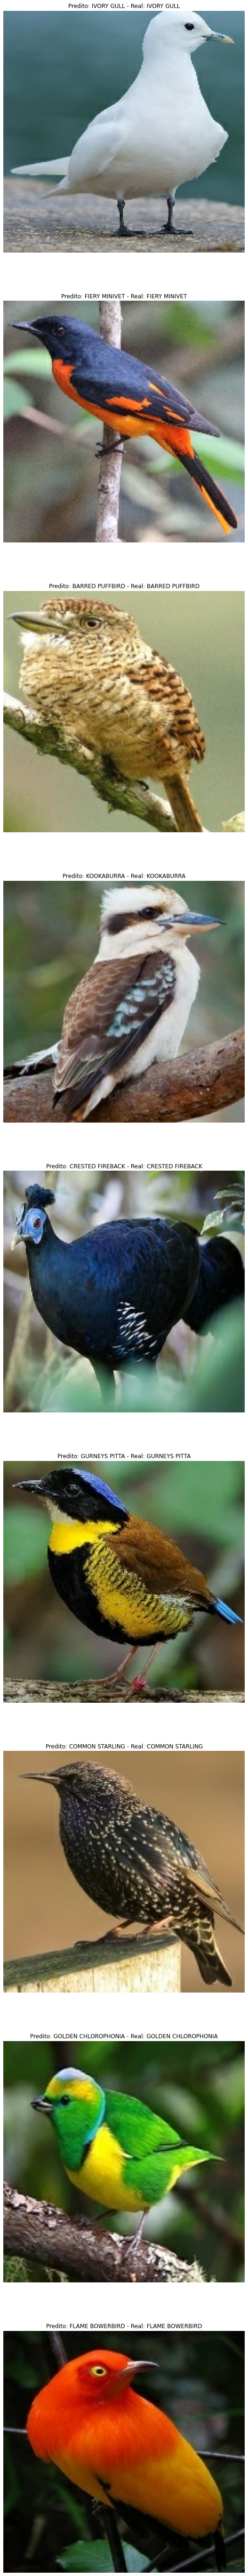

In [21]:
plt.figure(figsize=(10, 100))
for images, labels in test_ds.take(1):
    prediction = model.predict(images,batch_size=32)
    for i in range(9):
        ax = plt.subplot(9, 1, i+1)
        pred = np.argmax(prediction[i])
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(f'Predito: {class_names[pred]} - Real: {class_names[labels[i]]}')
        plt.axis('off')

In [22]:
#Visualize the result
results = model.evaluate(test_ds, verbose=0)

In [23]:
printmd(" ## Test Loss: {:.5f}".format(results[0]))
printmd("## Accuracy on the test set: {:.2f}%".format(results[1] * 100))

 ## Test Loss: 0.17545

## Accuracy on the test set: 95.07%

In [31]:
test_ds_unbatch = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=None,
    shuffle=False,
    image_size=(image_height, image_width),
    batch_size=image_height,
)
images = list(test_ds_unbatch.map(lambda x, y: x))
labels = list(test_ds_unbatch.map(lambda x, y: y))

Found 2250 files belonging to 450 classes.


In [32]:
y_test = np.concatenate([y for x, y in test_ds_unbatch], axis=0)
prediction = model.predict(test_ds_unbatch)
pred = np.argmax(prediction,axis=1)
print(pred)    
from sklearn.metrics import accuracy_score

accuracy_score(pred,y_test)

11/11 [==============================] - 3s 233ms/step
[  0   0   0 ... 449 113 449]


0.9506666666666667

In [40]:
#save model
model.save('/content/drive/MyDrive/Colab Notebooks/bird-species.h5')